# Exploring overfitting

### Imports

In [1]:
import numpy as np

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### Settings

In [2]:
# number of samples in the data set
N_SAMPLES = 2000
# ratio between training and test sets
TEST_SIZE = 0.2
# boundary of the graph
GRID_PADDING = 0.5
GRID_STEP = 0.01
# number of iterations of the neural network
N_EPOCHS = 300
# index of the layer we want to visualize
LAYER_INDEX = 2
# directory in which the visualizations will be saved
OUTPUT_DIR = "early_stopping"

### Create artificial dataset

In [3]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.4, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=42)

### Definition of grid

In [4]:
x_min, x_max = X[:, 0].min() - GRID_PADDING, X[:, 0].max() + GRID_PADDING
y_min, y_max = X[:, 1].min() - GRID_PADDING, X[:, 1].max() + GRID_PADDING
XX, YY = np.meshgrid(np.arange(x_min, x_max, GRID_STEP), np.arange(y_min, y_max, GRID_STEP))

### Auxiliary plotting function

In [5]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name, XX=None, YY=None, preds=None):
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    axes = plt.gca()
    axes.set_xlim([x_min,x_max])
    axes.set_ylim([y_min,y_max])
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 0.6, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    # plt.savefig(file_name)
    # plt.close()

In [6]:
# the function of creating a weight matrix graph
def plot_weights_matrix(model, layer_index, plot_name, file_name):
    weights = model.layers[LAYER_INDEX].get_weights()[0]
    min_val = round(weights.min(), 2)
    max_val = round(weights.max(), 2)
    shape = weights.shape
    X = np.array(range(shape[1]))
    Y = np.array(range(shape[0]))
    X, Y = np.meshgrid(X, Y)
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    plt.title("\n" + plot_name + "\n[MIN: " + str(min_val) + ", MAX: " + str(max_val) + "]", fontsize=20, y=1.05)
    surf = ax.plot_surface(X, Y, weights, cmap=plt.get_cmap('rainbow'), linewidth=0)
    # plt.savefig("./" + OUTPUT_DIR + "/" + file_name + ".png")
    # plt.close()

In [7]:
# precede the number with zeros, creating a thong of a certain length
def makeIndexOfLength(index, length):
    indexStr = str(index)
    return ('0' * (length - len(indexStr)) + indexStr)

In [14]:
# the auxiliary function forming loss and accuracy graph
def make_model_loss_and_acc_graph(epoch, logs):
    acc_train_history.append(logs['acc'])
    loss_train_history.append(logs['loss'])
    acc_test_history.append(logs['val_acc'])
    loss_test_history.append(logs['val_loss'])
    
    last_10_acc_train_history = acc_train_history[-10:]
    last_10_acc_test_history = acc_test_history[-10:]
    
    average_10_acc_train_history.append(sum(last_10_acc_train_history)/len(last_10_acc_train_history))
    average_10_acc_test_history.append(sum(last_10_acc_test_history)/len(last_10_acc_test_history))
    
    plt.figure(figsize=(12,8))
    sns.set_style("whitegrid")
    plt.plot(average_10_acc_train_history)
    plt.plot(average_10_acc_test_history)
    plt.title('Model acc - train set vs cross-validation set - epoch: ' + makeIndexOfLength(epoch, 3), fontsize=20)
    plt.ylabel('acc')
    plt.xlabel('iterations')
    plt.xlim([0,N_EPOCHS])
    plt.legend(['train set acc', 'test set acc'], loc='upper left')
    plt.savefig("./" + OUTPUT_DIR + "/acc_" + makeIndexOfLength(epoch, 3) + ".png")
    plt.close()

### Visualization of the data set

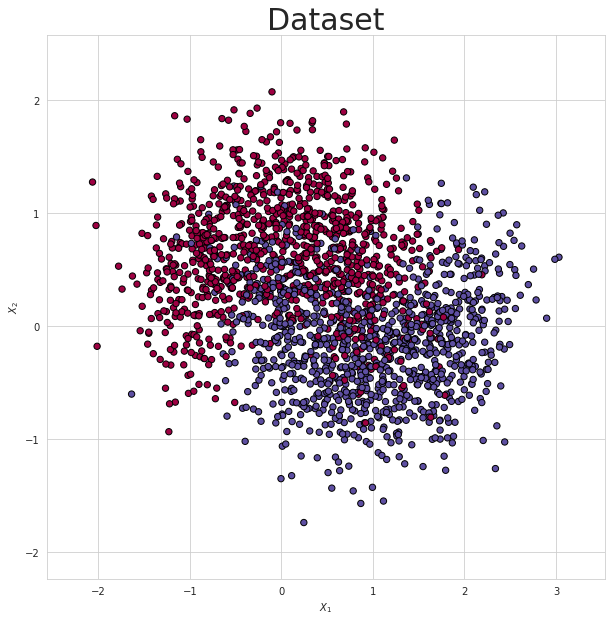

In [9]:
make_plot(X, y, "Dataset", "dataset.png")

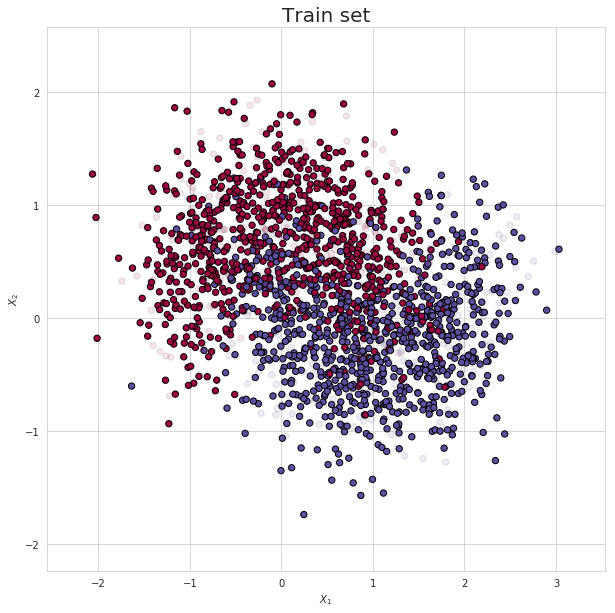

In [10]:
plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
axes.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title("Train set", fontsize=20)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black');
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black', alpha=0.1);

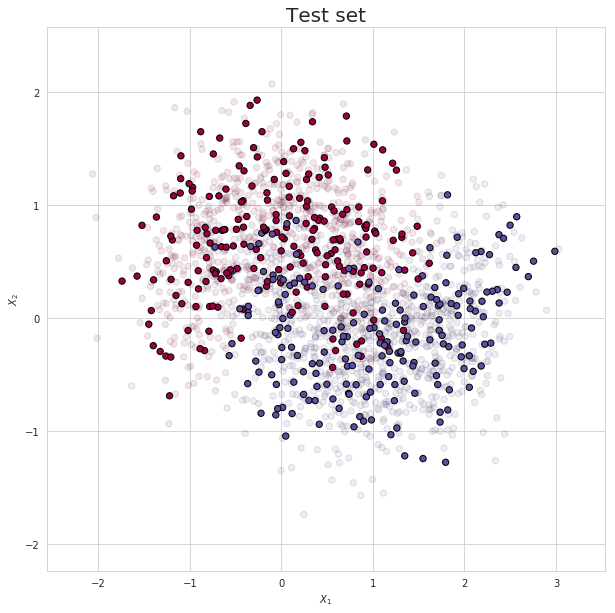

In [11]:
plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
axes.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title("Test set", fontsize=20)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black', alpha=0.1);
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black');

### Neural network without regularisation (high variance)

In [15]:
acc_train_history = []
acc_test_history = []
average_10_acc_train_history = []
average_10_acc_test_history = []
loss_train_history = []
loss_test_history = []

In [16]:
model = Sequential()
model.add(Dense(8, input_dim=2,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Adding callback functions that they will run in every epoch
testmodelcb = keras.callbacks.LambdaCallback(on_epoch_end=make_model_loss_and_acc_graph)

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0, validation_data=(X_test, y_test), callbacks=[testmodelcb])

In [ ]:
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print("Train accuracy: " + str(train_acc))
print("Test accuracy: " + str(test_acc))

## Thank you
---